# Vector Spaces

In [1]:
import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import gensim
from gensim import corpora, models, similarities
from nltk.corpus import stopwords

from collections import defaultdict
from pprint import pprint
from six import iteritems
import os

import numpy as np
import pandas as pd
import scipy.sparse

## Load Processed Dataframe

In [2]:
df = pd.read_pickle('pkl/df_stop_noun.pkl')
df.head(3)

,resume_text,resume_stopped,resume_nouns
0,"Petros Gazazyan North Hollywood, CA Werkervari...",petros gazazyan werkervaring engineer structur...,petros gazazyan engineer structural ttg engine...
1,"Travis London Java Software Engineer Tucson, A...",java software engineer bereid overal naartoe t...,java software engineer bereid overal naartoe t...
2,"Stephen A. Kraft Mechanical Engineer Seattle, ...",kraft mechanical engineer bereid overal naarto...,mechanical engineer bereid overal naartoe te v...


## Convert Series to List of Strings

In [3]:
resumes = df['resume_nouns'].tolist()
resumes[:1]

['petros gazazyan engineer structural ttg engineer december nonstructural equipment hospitals accordance asce cbc local codes extensive knowledge experience engineer programs enercalc etabs hilti profis remodel buildings beams columns foundations physical work remodel ensure work civil engineer student worker department public works september engineer meet publics needs transportation infrastructure project engineer project manages geographic presentation data gis system engineer report documents fund multimillion projects microsoft word access multiple projects bikeway coordination disaster reimbursement civil engineer']

# From Strings to Vectors

### Tokenize the documents, remove stop words and words that only appear once

In [4]:
# remove common words and tokenize
stoplist = set('for a of the and to in'.split())
texts = [[word for word in resume.split()] for resume in resumes]

# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

# remove words that occur less than n times
texts = [[token for token in text if frequency[token] > 2] for text in texts]

### Save Token Count Dictionary to File

In [5]:
dictionary = corpora.Dictionary(texts)

# store the dictionary, for future reference
dictionary.save('pkl/resume_token.dict')
print(dictionary)

Dictionary(42606 unique tokens: ['blog', 'dtac', 'melmark', 'ravishankar', 'plate']...)


### Convert Tokenized Resumes to Vectors

In [6]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('pkl/resume_token.mm', corpus)  # store to disk, for later use
for c in corpus[:1]:
    print(c)

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 8), (24, 2), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 2)]


## Corpus Streaming – One Document at a Time

In [7]:
# replace 'texts' with 'open(my_file.txt)' to read from files (one line in the file is a document)
# or loop through and open each individual file (?)
# either way, dictionary.doc2bow wants a list of words (aka - line.lower().split())
class MyCorpus(object):
    def __iter__(self):
        for line in texts:
            yield dictionary.doc2bow(line)

In [8]:
# doesn't load the corpus into memory!
corpus_memory_friendly = MyCorpus()

### Similarly, to construct the dictionary without loading all texts into memory

In [9]:
_ = '''
# collect statistics about all tokens
dictionary = corpora.Dictionary(line.lower().split() for line in open('mycorpus.txt'))

# remove stop words and words that appear only once
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist 
            if stopword in dictionary.token2id]
once_ids = [tokenid for tokenid, docfreq in iteritems(dictionary.dfs) if docfreq == 1]

# remove stop words and words that appear only once
dictionary.filter_tokens(stop_ids + once_ids)

# remove gaps in id sequence after words that were removed
dictionary.compactify()
print(dictionary)
'''

# Transformation Interface

In [10]:
# load tokenized dictionary
if (os.path.exists('pkl/resume_token.dict')):
    dictionary = corpora.Dictionary.load('pkl/resume_token.dict')
    print('Tokenized dictionary LOADED as \'dictionary\'')
else:
    print('Tokenized dictionary NOT FOUND')

Tokenized dictionary LOADED as 'dictionary'


In [11]:
# load sparse vector matrix
if (os.path.exists('pkl/resume_token.mm')):
    corpus = corpora.MmCorpus('pkl/resume_token.mm')
    print('Sparse matrix LOADED as \'corpus\'')
else:
    print('Sparse matrix NOT FOUND')

Sparse matrix LOADED as 'corpus'


### TF-IDF Transformation

In [12]:
# step 1 -- initialize a model
tfidf_mdl = models.TfidfModel(corpus) 

Calling `model[corpus]` only creates a wrapper around the old corpus document stream – actual conversions are done on-the-fly, during document iteration. We cannot convert the entire corpus at the time of calling corpus_transformed = model[corpus], because that would mean storing the result in main memory, and that contradicts gensim’s objective of memory-indepedence. If you will be iterating over the transformed corpus_transformed multiple times, and the transformation is costly, serialize the resulting corpus to disk first and continue using that.

In [13]:
# step 2 -- use the model to transform vectors
corpus_tfidf = tfidf_mdl[corpus]

# view one resume
for doc in corpus_tfidf[:1]:
    print(doc)

[(0, 0.12705076770557971), (1, 0.06377110336650212), (2, 0.09304234590263899), (3, 0.03342961055655677), (4, 0.1395617103203956), (5, 0.13250386516308085), (6, 0.09680854473772918), (7, 0.24076463463471334), (8, 0.0980051286628594), (9, 0.07040721516118742), (10, 0.20574699587827577), (11, 0.2161169650187463), (12, 0.22468198619888557), (13, 0.11403900042493938), (14, 0.034157661088542554), (15, 0.11179241312430775), (16, 0.09405305134763944), (17, 0.052554252572093986), (18, 0.03665784349785861), (19, 0.11594974813912941), (20, 0.20574699587827577), (21, 0.06341631239679332), (22, 0.012774090337684932), (23, 0.2371183588095541), (24, 0.3738304066302166), (25, 0.11664418249455692), (26, 0.019027298654655692), (27, 0.07450516016591763), (28, 0.04298475499697612), (29, 0.043082358422421516), (30, 0.01611997031211144), (31, 0.05366451753003983), (32, 0.04183226657161238), (33, 0.03666382612084938), (34, 0.04492723025002896), (35, 0.09791135685868489), (36, 0.03190221139393047), (37, 0.257

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
n_features = 1000

tfidf_vec = TfidfVectorizer(input='content', ngram_range=(1, 3), max_df=0.9, min_df=2, 
                max_features=n_features, norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

tfidf_vec_prep = tfidf_vec.fit_transform(resumes)

In [15]:
from sklearn.cluster import KMeans
from sklearn import metrics

km = KMeans(n_clusters=8, init='k-means++', max_iter=100, n_init=1)

km_mdl = km.fit_predict(tfidf_vec_prep)

In [17]:
# Determine your k range
k_range = range(1,20)

# fit the kmeans model for each n_clusters = k
k_means_var = [KMeans(n_clusters=k).fit(tfidf_vec_prep) for k in k_range]

# pull out the cluster centers for each model
centroids = [X.cluster_centers_ for X in k_means_var]

In [47]:
from scipy.spatial.distance import cdist, pdist

# calculate the euclidean distance from each point to each cluster center
k_euclid = [cdist(tfidf_vec_prep.toarray(), cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis=1) for ke in k_euclid]

# total within-cluster sum of squares
wcss = [sum(d**2) for d in dist]

# the total sum of squares
tss = sum(pdist(tfidf_vec_prep.toarray())**2)/tfidf_vec_prep.shape[1]

# the between-cluster sum of squares
bss = tss - wcss

KeyboardInterrupt: 

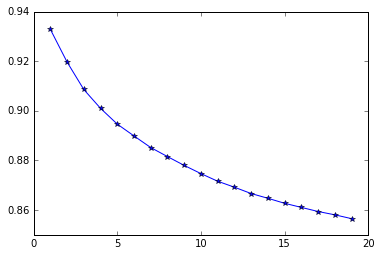

In [49]:
import numpy as np
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

##### cluster data into K=1..10 clusters #####
K = range(1,20)

# scipy.cluster.vq.kmeans
KM = [kmeans(tfidf_vec_prep.toarray(),k) for k in K]
centroids = [cent for (cent,var) in KM]   # cluster centroids

# alternative: scipy.spatial.distance.cdist
D_k = [cdist(tfidf_vec_prep.toarray(), cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/tfidf_vec_prep.shape[0] for d in dist]

##### plot ###
kIdx = 2

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')

In [125]:
import seaborn as sns
sns.set_style("white")
sns.set_context("poster", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.set_palette("Set2")
colors = sns.color_palette("BrBG", 5)

In [128]:
# make figure
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)

# color
colors = sns.color_palette("BrBG", 10)

# plots
ax.plot(K, avgWithinSS, marker='o', color=colors[-1], alpha=0.5)

# labels/titles
plt.legend(loc="best")
plt.title('Elbow for K-Means')
plt.xlabel('Number of Clusters')
plt.ylabel('Avg. Within-Cluster Sum of Squares')

# remove border
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# show grid
ax.xaxis.grid(True, alpha=0.2) 
ax.yaxis.grid(True, alpha=0.2) 

# plot that biddy
plt.savefig('data/pics/{0}.png'.format('KMeans_elbow'), bbox_inches='tight')
plt.close(fig)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [97]:
import numpy as np
from scipy.cluster.vq import kmeans
from scipy.spatial.distance import cdist,pdist
from sklearn import datasets
from sklearn.decomposition import RandomizedPCA
from matplotlib import pyplot as plt
from matplotlib import cm

# perform PCA dimensionality reduction
pca = RandomizedPCA(n_components=2).fit(tfidf_vec_prep.toarray())
X = pca.transform(tfidf_vec_prep.toarray())

##### cluster data into K=1..20 clusters #####
K_MAX = 20
KK = range(1,K_MAX+1)

KM = [kmeans(X,k) for k in KK]
centroids = [cent for (cent,var) in KM]
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]

tot_withinss = [sum(d**2) for d in dist]  # Total within-cluster sum of squares
totss = sum(pdist(X)**2)/X.shape[0]       # The total sum of squares
betweenss = totss - tot_withinss          # The between-cluster sum of squares

##### plots #####
kIdx = 4        # K=10
clr = cm.spectral( np.linspace(0,1,10) ).tolist()
mrk = 'os^p<dvh8>+x.'

In [146]:
# make figure
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)

# color
colors = sns.color_palette("BrBG", 5)

# plots
#ax.plot(K, avgWithinSS, marker='o', color=colors[-1], alpha=0.5)
ax.plot(KK, betweenss/totss*100, marker='o', color=colors[-1], alpha=0.5)
ax.plot(KK[kIdx], betweenss[kIdx]/totss*100, marker='o', markersize=25, color=colors[0], alpha=0.5)

# labels/titles
plt.legend(loc="best")
plt.title('Elbow for KMeans Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of variance explained (%)')

ax.set_xlim((-0.1,20.5))
ax.set_ylim((-0.5,100))

# remove border
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# show grid
ax.xaxis.grid(True, alpha=0.2) 
ax.yaxis.grid(True, alpha=0.2) 

# plot that biddy
plt.savefig('data/pics/{0}.png'.format('KMeans_elbow_var'), bbox_inches='tight')
plt.close(fig)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [147]:
# make figure
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)

# plots
for i in range(kIdx+1):
    ind = (cIdx[kIdx]==i)
    ax.scatter(X[ind,0],X[ind,1], s=65, c=colors[i], marker=mrk[i], 
               label='Cluster {0}'.format(i), alpha=1)

# labels/titles
plt.legend(loc='lower right')
plt.title('K={0} Clusters'.format(KK[kIdx]))

ax.set_xlim((-.5,.5))
ax.set_ylim((-.5,.5))

# remove border
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# show grid
ax.xaxis.grid(True, alpha=0.2) 
ax.yaxis.grid(True, alpha=0.2) 

# plot that biddy
plt.savefig('data/pics/{0}.png'.format('KMeans_{0}_clusters'.format(KK[kIdx])), bbox_inches='tight')
plt.close(fig)

In [16]:
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler

dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine', algorithm='brute', 
                leaf_size=30, p=None, random_state=None)

dbscan_mdl = dbscan.fit_predict(tfidf_vec_prep)

# Latent Semantic Indexing Topics

In [17]:
num_topics = 100

# initialize an LSI transformation
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=num_topics)
corpus_lsi = lsi[corpus_tfidf]

In [113]:
# the topics are printed to log
a = lsi.print_topics(8)
a[0]

(0,
 '0.149*"sql" + 0.108*"hadoop" + 0.107*"analysis" + 0.107*"server" + 0.103*"sales" + 0.102*"project" + 0.102*"report" + 0.094*"database" + 0.094*"system" + 0.091*"hive"')

In [19]:
for doc in corpus_lsi[800]: # both bow->tfidf and tfidf->lsi transformations are actually executed here, on the fly
    pass
    #print(doc)

# Model Save & Load

In [20]:
lsi.save('pkl/lsi_mdl.lsi')
lsi = models.LsiModel.load('pkl/lsi_mdl.lsi')

# LDA Topics

In [21]:
lda_mdl = models.LdaModel(corpus, id2word=dictionary, num_topics=20)

In [22]:
lda_mdl.top_topics
pprint(lda_mdl.print_topics(10))

[(1,
  '0.018*data + 0.015*system + 0.014*manage + 0.013*support + '
  '0.013*intelligence + 0.012*training + 0.011*information + 0.011*security + '
  '0.010*operations + 0.010*program'),
 (13,
  '0.030*test + 0.022*project + 0.021*data + 0.018*system + 0.017*requirements '
  '+ 0.014*manage + 0.013*team + 0.011*sap + 0.011*report + 0.010*quality'),
 (2,
  '0.028*engineer + 0.009*project + 0.008*system + 0.008*test + 0.008*analysis '
  '+ 0.007*materials + 0.006*control + 0.006*data + 0.005*experience + '
  '0.005*equipment'),
 (0,
  '0.024*system + 0.020*c + 0.020*software + 0.015*data + 0.010*engineer + '
  '0.009*manage + 0.009*java + 0.008*application + 0.008*service + '
  '0.008*linux'),
 (3,
  '0.026*data + 0.020*service + 0.019*customer + 0.018*skills + 0.015*entry + '
  '0.010*office + 0.009*work + 0.008*information + 0.008*microsoft + '
  '0.007*customers'),
 (14,
  '0.040*manage + 0.025*analysis + 0.018*report + 0.015*project + 0.012*data + '
  '0.012*process + 0.009*team + 0

In [116]:
print(corpus)

MmCorpus(17049 documents, 42606 features, 3131686 non-zero entries)


In [117]:
doc = df.iloc[0]['resume_nouns']
vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lsi = lsi[vec_bow] # convert the query to LSI space
print(vec_lsi)

[(0, 2.374975010869965), (1, 0.51728887522253952), (2, -0.058935199530753268), (3, 0.3578493537974749), (4, 1.560417648600577), (5, -1.9931029846659232), (6, 0.58697139609914861), (7, 1.437193124041608), (8, -0.38633595032575146), (9, -2.3068352804125016), (10, 0.77482570234627612), (11, -0.66082521176920128), (12, -2.0221618401059822), (13, 1.3229424544863675), (14, -0.29408524037515837), (15, -1.0569710323996966), (16, 1.110889840043604), (17, 1.3434022602282594), (18, -0.095802335904933394), (19, -0.80089048085959047), (20, -0.64832039201675884), (21, 1.35059095621303), (22, 0.36313071163680766), (23, 0.23008512654094881), (24, -1.4704302056681957), (25, -0.51110545886820391), (26, 1.5065962351771218), (27, -0.85864630999976976), (28, -0.27005311330166226), (29, 1.3357001963834654), (30, 0.11920370036201439), (31, 0.20935482520268536), (32, 0.58140672694418549), (33, 0.86476990150558442), (34, 0.21906262257842274), (35, 1.2623527033747142), (36, 0.47122700487966684), (37, 0.14754992

# Cosine Similarity

In [118]:
index = similarities.MatrixSimilarity(lsi[corpus]) # transform corpus to LSI space and index it

In [120]:
index.save('pkl/resume_stopped.index')
index = similarities.MatrixSimilarity.load('pkl/resume_stopped.index')

In [138]:
sims = index[vec_lsi] # perform a similarity query against the corpus

# (document_number, document_similarity)
sim_lst = list(enumerate(sims))

In [139]:
import operator
sim_lst.sort(key=operator.itemgetter(1), reverse=True)

In [141]:
# comparing resumes within resumes
sim_lst[1:6]

[(537, 0.9609338),
 (468, 0.95680636),
 (39, 0.95674884),
 (189, 0.95360476),
 (737, 0.94994313)]

In [144]:
' '.join(texts[0])

'engineer structural engineer december nonstructural equipment hospitals accordance asce cbc local codes extensive knowledge experience engineer programs enercalc etabs hilti profis remodel buildings beams columns foundations physical work remodel ensure work civil engineer student worker department public works september engineer meet publics needs transportation infrastructure project engineer project manages geographic presentation data gis system engineer report documents fund multimillion projects microsoft word access multiple projects coordination disaster reimbursement civil engineer'